In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from dataset import kline_data, prepare_prediction_data
from models import rnn_gru
from PyEMD import CEEMDAN
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
if not os.path.exists('plots'):
    os.mkdir('plots')

In [3]:
btc = kline_data()
btc['d_oc_p'] = (btc['close'] - btc['open']) / btc['open']
btc.tail()

Last saved data candle close time: 2021-08-04 00:00:00


,open_time,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,d_oc_p
1443,2021-07-30 00:00:00,40018.49,42316.71,38313.23,42206.37,73602.784805,2021-07-31 00:00:00,2.939834e+09,1797012,37730.426862,1.509173e+09,0.0,0.054672
1444,2021-07-31 00:00:00,42206.36,42448.00,41000.15,41461.83,44849.791012,2021-08-01 00:00:00,1.868286e+09,1565380,22844.245050,9.518879e+08,0.0,-0.017640
1445,2021-08-01 00:00:00,41461.84,42599.00,39422.01,39845.44,53953.186326,2021-08-02 00:00:00,2.227567e+09,1603964,25796.753795,1.066580e+09,0.0,-0.038985
1446,2021-08-02 00:00:00,39850.27,40480.01,38690.00,39147.82,50837.351954,2021-08-03 00:00:00,2.010928e+09,1162878,24558.005343,9.715967e+08,0.0,-0.017627
1447,2021-08-03 00:00:00,39146.86,39780.00,37642.03,38207.05,57117.435853,2021-08-04 00:00:00,2.195361e+09,1379871,27683.466598,1.064119e+09,0.0,-0.024007


In [4]:
data = np.array(btc['d_oc_p'])
ceemdan = CEEMDAN()
imfs = ceemdan.ceemdan(data).T
imfs.shape

(1448, 9)

In [5]:
input_size = 20
train_pred = []
test_pred = []
for i in range(imfs.shape[1]):
    print(f'*** IMF {i + 1} / {imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(imfs[:, i], axis=-1)))
    x, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x.shape[0]
    x_train = np.expand_dims(x[:int(n_samples * 0.85), :], axis=-1)
    x_test = np.expand_dims(x[int(n_samples * 0.85):, :], axis=-1)
    y_train = y[:int(n_samples * 0.85)]
    y_test = y[int(n_samples * 0.85):]
    
    model = rnn_gru(input_size=input_size)
    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_oc_p_1d.h5')
    cb = [ea, cp]
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict(x_test)))
    test_pred.append(y_test_pred)
    
    y_train_pred = np.squeeze(minmax.inverse_transform(model.predict(x_train)))
    train_pred.append(y_train_pred)

*** IMF 1 / 9
Epoch 1/100
27/27 [==============================] - 5s 43ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 2/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 3/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 4/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 5/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 6/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 7/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 8/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0049 - va

27/27 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/100
27/27 [==============================] - 1s 25ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/100
27/27 [==============================] - 1s 24ms/step - loss: 7.9432e-04 - val_loss: 0.0011
Epoch 10/100
27/27 [==============================] - 1s 24ms/step - loss: 7.3198e-04 - val_loss: 8.6598e-04
Epoch 11/100
27/27 [==============================] - 1s 28ms/step - loss: 5.3476e-04 - val_loss: 8.5965e-04
Epoch 12/100
27/27 [==============================] - 1s 27ms/step - loss: 5.8237e-04 - val_loss: 8.0462e-04
Epoch 13/100
27/27 [==============================] - 1s 26ms/step - loss: 4.7132e-04 - val_loss: 8.0225e-04
Epoch 14/100
27/27 [==============================] - 1s 28ms/step - loss: 4.2997e-04 - val_loss: 7.7886e-04
Epoch 15/100
27/27 [==============================] - 1s 25ms/s

27/27 [==============================] - 1s 24ms/step - loss: 9.4628e-05 - val_loss: 2.7139e-04
Epoch 82/100
27/27 [==============================] - 1s 27ms/step - loss: 9.5516e-05 - val_loss: 2.7780e-04
Epoch 83/100
27/27 [==============================] - 1s 26ms/step - loss: 8.8510e-05 - val_loss: 2.7718e-04
Epoch 84/100
27/27 [==============================] - 1s 24ms/step - loss: 8.8183e-05 - val_loss: 2.8709e-04
Epoch 85/100
27/27 [==============================] - 1s 27ms/step - loss: 9.0389e-05 - val_loss: 2.8232e-04
Epoch 86/100
27/27 [==============================] - 1s 28ms/step - loss: 1.3326e-04 - val_loss: 3.7753e-04
Epoch 87/100
27/27 [==============================] - 1s 23ms/step - loss: 1.0459e-04 - val_loss: 2.7352e-04
Epoch 88/100
27/27 [==============================] - 1s 23ms/step - loss: 8.5127e-05 - val_loss: 2.9473e-04
Epoch 89/100
27/27 [==============================] - 1s 26ms/step - loss: 7.7041e-05 - val_loss: 2.7895e-04
Epoch 90/100
27/27 [============

27/27 [==============================] - 1s 28ms/step - loss: 1.9384e-04 - val_loss: 8.7157e-05
Epoch 57/100
27/27 [==============================] - 1s 26ms/step - loss: 2.0203e-04 - val_loss: 6.5511e-05
Epoch 58/100
27/27 [==============================] - 1s 26ms/step - loss: 2.0282e-04 - val_loss: 1.0545e-04
Epoch 59/100
27/27 [==============================] - 1s 27ms/step - loss: 1.6163e-04 - val_loss: 1.1217e-04
Epoch 60/100
27/27 [==============================] - 1s 27ms/step - loss: 1.6413e-04 - val_loss: 1.4213e-04
Epoch 61/100
27/27 [==============================] - 1s 29ms/step - loss: 1.7761e-04 - val_loss: 6.2313e-05
Epoch 62/100
27/27 [==============================] - 1s 26ms/step - loss: 1.6364e-04 - val_loss: 3.3046e-04
Epoch 63/100
27/27 [==============================] - 1s 23ms/step - loss: 2.0626e-04 - val_loss: 6.2416e-05
Epoch 64/100
27/27 [==============================] - 1s 25ms/step - loss: 1.5231e-04 - val_loss: 6.3482e-05
Epoch 65/100
27/27 [============

27/27 [==============================] - 1s 28ms/step - loss: 3.1345e-04 - val_loss: 1.7473e-04
Epoch 31/100
27/27 [==============================] - 1s 27ms/step - loss: 3.1171e-04 - val_loss: 1.6169e-04
Epoch 32/100
27/27 [==============================] - 1s 28ms/step - loss: 3.1551e-04 - val_loss: 1.3982e-04
Epoch 33/100
27/27 [==============================] - 1s 25ms/step - loss: 2.8269e-04 - val_loss: 1.0711e-04
Epoch 34/100
27/27 [==============================] - 1s 27ms/step - loss: 2.4386e-04 - val_loss: 1.0808e-04
Epoch 35/100
27/27 [==============================] - 1s 27ms/step - loss: 2.4989e-04 - val_loss: 9.4577e-05
Epoch 36/100
27/27 [==============================] - 1s 29ms/step - loss: 2.3802e-04 - val_loss: 1.3321e-04
Epoch 37/100
27/27 [==============================] - 1s 24ms/step - loss: 2.5151e-04 - val_loss: 9.9768e-05
Epoch 38/100
27/27 [==============================] - 1s 25ms/step - loss: 2.1169e-04 - val_loss: 9.7835e-05
Epoch 39/100
27/27 [============

Epoch 5/100
27/27 [==============================] - 1s 29ms/step - loss: 9.4426e-04 - val_loss: 0.0031
Epoch 6/100
27/27 [==============================] - 1s 29ms/step - loss: 6.0965e-04 - val_loss: 0.0021e-0
Epoch 7/100
27/27 [==============================] - 1s 34ms/step - loss: 3.3422e-04 - val_loss: 0.0011
Epoch 8/100
27/27 [==============================] - 1s 34ms/step - loss: 1.8399e-04 - val_loss: 9.5490e-04
Epoch 9/100
27/27 [==============================] - 1s 37ms/step - loss: 1.7033e-04 - val_loss: 8.1663e-04
Epoch 10/100
27/27 [==============================] - 1s 37ms/step - loss: 1.6511e-04 - val_loss: 9.1718e-04
Epoch 11/100
27/27 [==============================] - 1s 41ms/step - loss: 1.5075e-04 - val_loss: 8.1033e-04
Epoch 12/100
27/27 [==============================] - 1s 39ms/step - loss: 1.4333e-04 - val_loss: 8.0863e-04
Epoch 13/100
27/27 [==============================] - 1s 47ms/step - loss: 1.4290e-04 - val_loss: 7.9096e-04
Epoch 14/100
27/27 [=============

27/27 [==============================] - 1s 49ms/step - loss: 8.8139e-06 - val_loss: 2.0264e-04
Epoch 81/100
27/27 [==============================] - 1s 41ms/step - loss: 1.3568e-05 - val_loss: 2.0856e-04
Epoch 82/100
27/27 [==============================] - 1s 49ms/step - loss: 1.4095e-05 - val_loss: 2.0453e-04
Epoch 83/100
27/27 [==============================] - 1s 46ms/step - loss: 1.2547e-05 - val_loss: 1.9842e-04
Epoch 84/100
27/27 [==============================] - 1s 40ms/step - loss: 9.1803e-06 - val_loss: 2.0203e-04
Epoch 85/100
27/27 [==============================] - 1s 39ms/step - loss: 1.4479e-05 - val_loss: 2.3459e-04
Epoch 86/100
27/27 [==============================] - 1s 34ms/step - loss: 2.5149e-05 - val_loss: 1.9065e-04
Epoch 87/100
27/27 [==============================] - 1s 35ms/step - loss: 1.7525e-05 - val_loss: 2.0924e-04
Epoch 88/100
27/27 [==============================] - 1s 37ms/step - loss: 1.3272e-05 - val_loss: 1.9684e-04
Epoch 89/100
27/27 [============

27/27 [==============================] - 1s 33ms/step - loss: 4.7420e-05 - val_loss: 9.6960e-05
Epoch 56/100
27/27 [==============================] - 1s 31ms/step - loss: 4.1530e-05 - val_loss: 9.8050e-05
Epoch 57/100
27/27 [==============================] - 1s 32ms/step - loss: 2.7461e-05 - val_loss: 8.4710e-05
Epoch 58/100
27/27 [==============================] - 1s 37ms/step - loss: 3.6097e-05 - val_loss: 7.4126e-05
Epoch 59/100
27/27 [==============================] - 1s 35ms/step - loss: 2.8090e-05 - val_loss: 5.2672e-05
Epoch 60/100
27/27 [==============================] - 1s 35ms/step - loss: 2.5126e-05 - val_loss: 7.5076e-05
Epoch 61/100
27/27 [==============================] - 1s 37ms/step - loss: 2.3775e-05 - val_loss: 5.9328e-05
Epoch 62/100
27/27 [==============================] - 1s 38ms/step - loss: 2.6094e-05 - val_loss: 6.2073e-05
Epoch 63/100
27/27 [==============================] - 1s 38ms/step - loss: 1.7431e-05 - val_loss: 6.1704e-05
Epoch 64/100
27/27 [============

Epoch 31/100
27/27 [==============================] - 1s 38ms/step - loss: 1.0602e-04 - val_loss: 9.8303e-06
Epoch 32/100
27/27 [==============================] - 1s 35ms/step - loss: 1.1295e-04 - val_loss: 1.4578e-05
Epoch 33/100
27/27 [==============================] - 1s 38ms/step - loss: 9.5338e-05 - val_loss: 5.7621e-06
Epoch 34/100
27/27 [==============================] - 1s 35ms/step - loss: 1.0894e-04 - val_loss: 2.9023e-05
Epoch 35/100
27/27 [==============================] - 1s 34ms/step - loss: 1.1511e-04 - val_loss: 1.1095e-05
Epoch 36/100
27/27 [==============================] - 1s 36ms/step - loss: 9.5911e-05 - val_loss: 6.6919e-06
Epoch 37/100
27/27 [==============================] - 1s 40ms/step - loss: 9.6436e-05 - val_loss: 1.0738e-05
Epoch 38/100
27/27 [==============================] - 1s 35ms/step - loss: 1.0006e-04 - val_loss: 1.1021e-05
Epoch 39/100
27/27 [==============================] - 1s 35ms/step - loss: 9.6987e-05 - val_loss: 3.9248e-05
Epoch 40/100
27/27 

27/27 [==============================] - 1s 34ms/step - loss: 6.4289e-04 - val_loss: 4.8698e-04
Epoch 18/100
27/27 [==============================] - 1s 50ms/step - loss: 5.2583e-04 - val_loss: 6.3474e-04
Epoch 19/100
27/27 [==============================] - 2s 63ms/step - loss: 4.1366e-04 - val_loss: 6.5339e-04
Epoch 20/100
27/27 [==============================] - 1s 44ms/step - loss: 3.0107e-04 - val_loss: 5.6021e-04
Epoch 21/100
27/27 [==============================] - 2s 60ms/step - loss: 2.1887e-04 - val_loss: 6.2499e-04
Epoch 22/100
27/27 [==============================] - 2s 64ms/step - loss: 2.2066e-04 - val_loss: 8.3302e-04
Epoch 23/100
27/27 [==============================] - 2s 60ms/step - loss: 2.0199e-04 - val_loss: 5.4850e-04
Epoch 24/100
27/27 [==============================] - 2s 62ms/step - loss: 1.6100e-04 - val_loss: 3.0383e-04
Epoch 25/100
27/27 [==============================] - 1s 53ms/step - loss: 1.7067e-04 - val_loss: 2.8778e-04
Epoch 26/100
27/27 [============

27/27 [==============================] - 1s 33ms/step - loss: 3.4573e-05 - val_loss: 1.5629e-04
Epoch 93/100
27/27 [==============================] - 1s 32ms/step - loss: 2.6223e-05 - val_loss: 1.1010e-04
Test set MSE: 0.0011869866866618395


In [6]:
y_test_pred = np.sum(np.array(test_pred).T, axis=1)
y_test_pred.shape

(215,)

In [7]:
y_train_pred = np.sum(np.array(train_pred).T, axis=1)
y_train_pred.shape

(1213,)

In [11]:
test_open_prices = np.array(btc['open'])[-y_test_pred.shape[0]:]
test_close_prices = np.array(btc['close'])[-y_test_pred.shape[0]:]
train_open_prices = np.array(btc['open'])[input_size:-y_test_pred.shape[0]]
train_close_prices = np.array(btc['close'])[input_size:-y_test_pred.shape[0]]

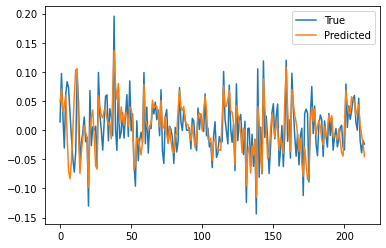

In [12]:
x, y = prepare_prediction_data(data, input_size=input_size)
n_samples = x.shape[0]
y_test = y[int(n_samples * 0.85):]

plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Predicted')
plt.legend()

In [14]:
d_oc_p_test = y_test_pred
d_oc_test = d_oc_p_test * test_open_prices
test_close_prices_pred = test_open_prices + d_oc_test

d_oc_p_train = y_train_pred
d_oc_train = d_oc_p_train * train_open_prices
train_close_prices_pred = train_open_prices + d_oc_train

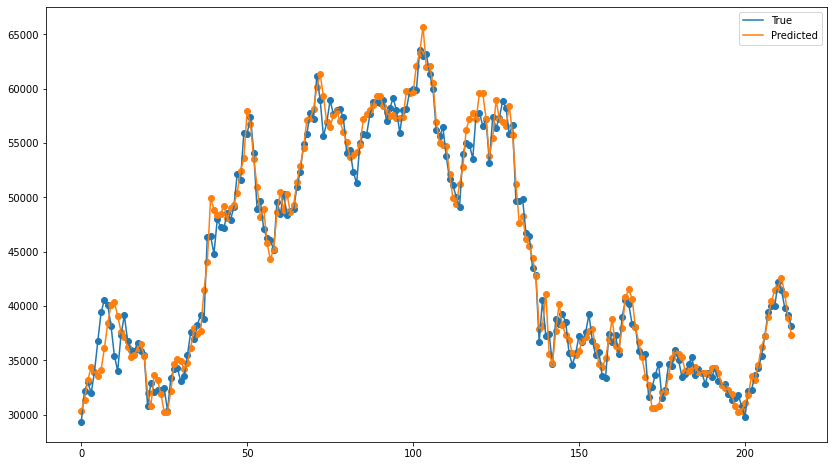

In [15]:
plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_pred)
plt.legend()

In [16]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_pred)}')

Test set MAE: 1194.8328413350077
Test set MAPE: 0.0280932425291743


In [19]:
error_train = train_close_prices - train_close_prices_pred
error_test = test_close_prices - test_close_prices_pred
print(error_train.shape, error_test.shape)

(1213,) (215,)


In [27]:
n_test_samples = error_test.shape[0]

In [22]:
all_error = np.concatenate((error_train, error_test))
all_error.shape

(1428,)

In [23]:
ceemdan = CEEMDAN()
error_imfs = ceemdan.ceemdan(all_error).T
error_imfs.shape

(1428, 10)

In [29]:
input_size = 20
test_pred = []
for i in range(error_imfs.shape[1]):
    print(f'*** IMF {i + 1} / {error_imfs.shape[1]} ***')
    minmax = MinMaxScaler()
    data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(error_imfs[:, i], axis=-1)))
    x, y = prepare_prediction_data(data_norm, input_size=input_size)
    n_samples = x.shape[0]
    x_train = np.expand_dims(x[:-n_test_samples, :], axis=-1)
    x_test = np.expand_dims(x[-n_test_samples:, :], axis=-1)
    y_train = y[:-n_test_samples]
    y_test = y[-n_test_samples:]
    
    model = rnn_gru(input_size=input_size)
    ea = EarlyStopping(patience=20)
    cp = ModelCheckpoint('saved_models/gru_d_oc_p_1d.h5')
    cb = [ea, cp]
    history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)
    
    print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')
    y_test_pred = np.squeeze(minmax.inverse_transform(model.predict(x_test)))
    test_pred.append(y_test_pred)

*** IMF 1 / 10 ***
Epoch 1/100
27/27 [==============================] - 6s 52ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/100
27/27 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
27/27 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0011

27/27 [==============================] - 1s 29ms/step - loss: 9.6462e-04 - val_loss: 0.0011
Epoch 81/100
27/27 [==============================] - 1s 28ms/step - loss: 9.4721e-04 - val_loss: 9.8980e-04
Epoch 82/100
27/27 [==============================] - 1s 26ms/step - loss: 9.0695e-04 - val_loss: 0.0010
Epoch 83/100
27/27 [==============================] - 1s 28ms/step - loss: 9.2197e-04 - val_loss: 0.0010
Epoch 84/100
27/27 [==============================] - 1s 29ms/step - loss: 9.4459e-04 - val_loss: 9.8270e-04
Epoch 85/100
27/27 [==============================] - 1s 26ms/step - loss: 9.1797e-04 - val_loss: 9.7628e-04
Epoch 86/100
27/27 [==============================] - 1s 29ms/step - loss: 9.0824e-04 - val_loss: 9.7401e-04
Epoch 87/100
27/27 [==============================] - 1s 26ms/step - loss: 9.0034e-04 - val_loss: 9.7053e-04
Epoch 88/100
27/27 [==============================] - 1s 29ms/step - loss: 9.0561e-04 - val_loss: 9.6764e-04
Test set MSE: 0.027578169479966164
*** IMF 2

27/27 [==============================] - 5s 44ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 2/100
27/27 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 4/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 6/100
27/27 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/100
27/27 [==============================] - 1s 19ms/step - loss: 8.2439e-04 - val_loss: 0.0013
Epoch 8/100
27/27 [==============================] - 1s 22ms/step - loss: 5.8014e-04 - val_loss: 0.0013
Epoch 9/100
27/27 [==============================] - 1s 23ms/step - loss: 5.1897e-04 - val_loss: 9.9231e-04
Epoch 10/100
27/27 [==============================] - 1s 22ms/step - loss: 3.9549e-04 - val_loss

27/27 [==============================] - 1s 26ms/step - loss: 3.5971e-05 - val_loss: 1.0827e-04
Epoch 77/100
27/27 [==============================] - 1s 26ms/step - loss: 2.9952e-05 - val_loss: 1.4379e-04
Epoch 78/100
27/27 [==============================] - 1s 27ms/step - loss: 3.2846e-05 - val_loss: 1.1961e-04
Epoch 79/100
27/27 [==============================] - 1s 29ms/step - loss: 3.4564e-05 - val_loss: 1.1070e-04
Epoch 80/100
27/27 [==============================] - 1s 28ms/step - loss: 3.2935e-05 - val_loss: 1.0040e-04
Epoch 81/100
27/27 [==============================] - 1s 23ms/step - loss: 3.1208e-05 - val_loss: 1.1720e-04
Epoch 82/100
27/27 [==============================] - 1s 26ms/step - loss: 2.6345e-05 - val_loss: 1.5048e-04
Epoch 83/100
27/27 [==============================] - 1s 26ms/step - loss: 3.1829e-05 - val_loss: 1.0982e-04
Epoch 84/100
27/27 [==============================] - 1s 28ms/step - loss: 2.9116e-05 - val_loss: 1.1036e-04
Epoch 85/100
27/27 [============

27/27 [==============================] - 1s 42ms/step - loss: 1.8383e-05 - val_loss: 8.2345e-05
Epoch 52/100
27/27 [==============================] - 1s 41ms/step - loss: 3.0048e-05 - val_loss: 8.8983e-05
Epoch 53/100
27/27 [==============================] - 1s 42ms/step - loss: 2.1072e-05 - val_loss: 9.1623e-05
Epoch 54/100
27/27 [==============================] - 1s 43ms/step - loss: 1.7646e-05 - val_loss: 7.6582e-05
Epoch 55/100
27/27 [==============================] - 1s 42ms/step - loss: 1.8015e-05 - val_loss: 8.0704e-05
Epoch 56/100
27/27 [==============================] - 1s 40ms/step - loss: 2.0427e-05 - val_loss: 7.1915e-05
Epoch 57/100
27/27 [==============================] - 1s 41ms/step - loss: 2.0588e-05 - val_loss: 1.2027e-04
Epoch 58/100
27/27 [==============================] - 1s 41ms/step - loss: 3.2646e-05 - val_loss: 1.0884e-04
Epoch 59/100
27/27 [==============================] - 1s 41ms/step - loss: 2.1334e-05 - val_loss: 7.3881e-05
Epoch 60/100
27/27 [============

Epoch 26/100
27/27 [==============================] - 1s 43ms/step - loss: 1.0432e-05 - val_loss: 2.8692e-05
Epoch 27/100
27/27 [==============================] - 1s 40ms/step - loss: 1.1321e-05 - val_loss: 3.6112e-05
Epoch 28/100
27/27 [==============================] - 1s 40ms/step - loss: 1.0316e-05 - val_loss: 3.2451e-05
Epoch 29/100
27/27 [==============================] - 1s 40ms/step - loss: 1.8813e-05 - val_loss: 1.0346e-04
Epoch 30/100
27/27 [==============================] - 1s 40ms/step - loss: 2.8987e-05 - val_loss: 2.4846e-05
Epoch 31/100
27/27 [==============================] - 1s 40ms/step - loss: 1.1359e-05 - val_loss: 2.5909e-05
Epoch 32/100
27/27 [==============================] - 1s 39ms/step - loss: 1.0550e-05 - val_loss: 2.9396e-05
Epoch 33/100
27/27 [==============================] - 1s 37ms/step - loss: 9.9284e-06 - val_loss: 2.8714e-05
Epoch 34/100
27/27 [==============================] - 1s 35ms/step - loss: 1.0953e-05 - val_loss: 3.4368e-05
Epoch 35/100
27/27 

*** IMF 6 / 10 ***
Epoch 1/100
27/27 [==============================] - 6s 73ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 2/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 9.1149e-04
Epoch 4/100
27/27 [==============================] - 1s 22ms/step - loss: 6.5893e-04 - val_loss: 5.0294e-04
Epoch 5/100
27/27 [==============================] - 1s 26ms/step - loss: 4.1710e-04 - val_loss: 3.2084e-04
Epoch 6/100
27/27 [==============================] - 1s 27ms/step - loss: 2.0075e-04 - val_loss: 3.8345e-04
Epoch 7/100
27/27 [==============================] - 1s 31ms/step - loss: 1.6502e-04 - val_loss: 1.9069e-04
Epoch 8/100
27/27 [==============================] - 1s 31ms/step - loss: 1.1204e-04 - val_loss: 1.3183e-04
Epoch 9/100
27/27 [==============================] - 1s 33ms/step - loss: 8.3932e-05 - val_loss: 1.1256e-04
Epoch 10/100
27/27 [=========

27/27 [==============================] - 1s 37ms/step - loss: 1.2796e-06 - val_loss: 4.1533e-06
Epoch 77/100
27/27 [==============================] - 1s 38ms/step - loss: 1.3732e-06 - val_loss: 6.2285e-06
Epoch 78/100
27/27 [==============================] - 1s 36ms/step - loss: 1.2152e-06 - val_loss: 4.4309e-06
Epoch 79/100
27/27 [==============================] - 1s 37ms/step - loss: 8.7034e-07 - val_loss: 2.8425e-06
Epoch 80/100
27/27 [==============================] - 1s 36ms/step - loss: 5.7272e-07 - val_loss: 2.8073e-06
Epoch 81/100
27/27 [==============================] - 1s 37ms/step - loss: 7.1659e-07 - val_loss: 5.7988e-06
Epoch 82/100
27/27 [==============================] - 1s 36ms/step - loss: 2.3247e-06 - val_loss: 6.5411e-06
Epoch 83/100
27/27 [==============================] - 1s 35ms/step - loss: 1.7787e-06 - val_loss: 2.5502e-06
Epoch 84/100
27/27 [==============================] - 1s 36ms/step - loss: 8.4959e-07 - val_loss: 3.0645e-06
Epoch 85/100
27/27 [============

27/27 [==============================] - 1s 38ms/step - loss: 1.4048e-07 - val_loss: 3.7475e-05
Epoch 52/100
27/27 [==============================] - 1s 37ms/step - loss: 2.8702e-07 - val_loss: 2.9020e-05
Epoch 53/100
27/27 [==============================] - 1s 38ms/step - loss: 3.6632e-07 - val_loss: 3.0584e-05
Epoch 54/100
27/27 [==============================] - 1s 37ms/step - loss: 2.3549e-07 - val_loss: 2.9312e-05
Epoch 55/100
27/27 [==============================] - 1s 36ms/step - loss: 3.5183e-07 - val_loss: 3.0429e-05
Epoch 56/100
27/27 [==============================] - 1s 35ms/step - loss: 3.3455e-07 - val_loss: 3.6496e-05
Epoch 57/100
27/27 [==============================] - 1s 33ms/step - loss: 1.8667e-07 - val_loss: 3.2734e-05
Epoch 58/100
27/27 [==============================] - 1s 33ms/step - loss: 1.1916e-07 - val_loss: 3.2414e-05
Epoch 59/100
27/27 [==============================] - 1s 33ms/step - loss: 2.6398e-07 - val_loss: 2.8091e-05
Epoch 60/100
27/27 [============

27/27 [==============================] - 1s 25ms/step - loss: 6.5089e-04 - val_loss: 0.0025
Epoch 5/100
27/27 [==============================] - 1s 26ms/step - loss: 5.6708e-04 - val_loss: 0.0027
Epoch 6/100
27/27 [==============================] - 1s 29ms/step - loss: 5.1114e-04 - val_loss: 0.0028
Epoch 7/100
27/27 [==============================] - 1s 34ms/step - loss: 4.9711e-04 - val_loss: 0.0027
Epoch 8/100
27/27 [==============================] - 1s 36ms/step - loss: 5.2969e-04 - val_loss: 0.0028
Epoch 9/100
27/27 [==============================] - 1s 38ms/step - loss: 4.9927e-04 - val_loss: 0.0027
Epoch 10/100
27/27 [==============================] - 1s 37ms/step - loss: 4.4106e-04 - val_loss: 0.0030e-
Epoch 11/100
27/27 [==============================] - 1s 37ms/step - loss: 4.2653e-04 - val_loss: 0.0030e-
Epoch 12/100
27/27 [==============================] - 1s 37ms/step - loss: 4.4861e-04 - val_loss: 0.0025
Epoch 13/100
27/27 [==============================] - 1s 38ms/step - 

In [30]:
error_test_pred = np.sum(np.array(test_pred).T, axis=1)
error_test_pred.shape

(215,)

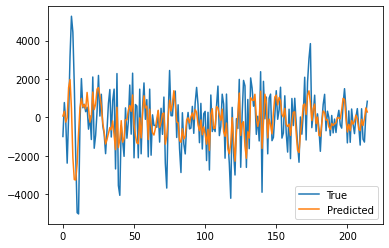

In [33]:
plt.plot(error_test, label='True')
plt.plot(error_test_pred, label='Predicted')
plt.legend()

In [34]:
test_close_prices_final_pred = test_close_prices_pred + error_test_pred

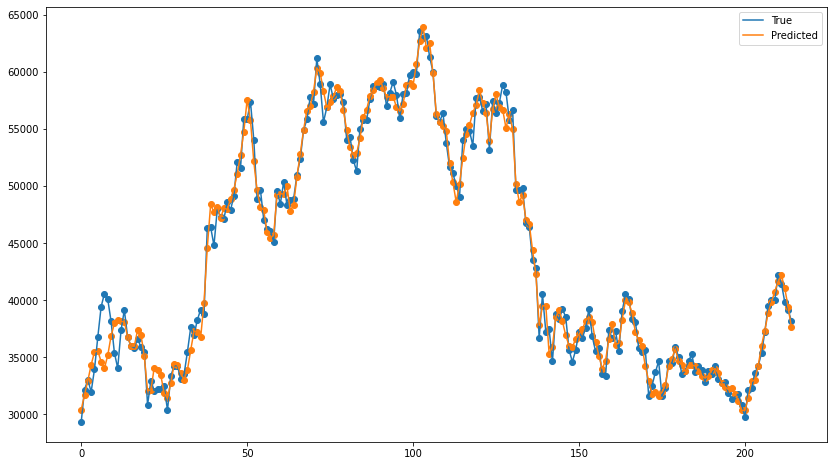

In [35]:
plt.figure(figsize=(14, 8))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_final_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_final_pred)
plt.legend()

In [36]:
print(f'Test set MAE: {mean_absolute_error(test_close_prices, test_close_prices_final_pred)}')
print(f'Test set MAPE: {mean_absolute_percentage_error(test_close_prices, test_close_prices_final_pred)}')

Test set MAE: 924.7579977709458
Test set MAPE: 0.02197556026585139
